## This Notebook contains:
- Reading the datset from Northeastern university
- Modelling for classification models
- Calculation of Error metrices
- Summarizing Models at the end


In [79]:
# Required Python Packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [36]:
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

Importing the dataset

In [37]:
dataset = pd.read_csv('../../Data/all_records_northeastern.csv')

Dropping the column, Unnamed as it is not necessary

In [38]:
dataset.drop(columns=['Unnamed: 0'],inplace=True)

In [39]:
dataset.head()

,gre_score,gre_score_quant,gre_score_verbal,test_score_toefl,undergraduation_score,work_ex,papers_published,status
0,316,164,152,99.0,3.12,12,0,reject
1,316,164,152,99.0,3.12,12,0,reject
2,316,160,156,114.0,2.97,0,0,reject
3,317,168,149,106.0,2.83,15,0,reject
4,317,161,156,106.0,2.01,0,0,reject


Count of accept and reject in dataset

In [40]:
dataset.status.value_counts()

reject    1079
accept     574
Name: status, dtype: int64

As we see from above stats, our data is baised so we need to resample the data, in order to balance the dataset

In [41]:

balanced_data=resample(dataset[dataset.status=='accept'],replace=True,n_samples=1000,random_state=123)
balanced_data=balanced_data.append(dataset[dataset.status=='reject'])

In [42]:
balanced_data.status.value_counts()

reject    1079
accept    1000
Name: status, dtype: int64

In [43]:
encoded_dataset=balanced_data

In [44]:
encoded_dataset.head(2)

,gre_score,gre_score_quant,gre_score_verbal,test_score_toefl,undergraduation_score,work_ex,papers_published,status
1589,314,165,149,100.0,2.9,0,2,accept
1444,315,162,153,100.0,3.3,60,0,accept


As we see from above stats, our data is baised so we need to resample the data, in order to balance the dataset

In [45]:
X=encoded_dataset[['gre_score_quant','gre_score_verbal','test_score_toefl','undergraduation_score','work_ex','papers_published']].copy()
Y=encoded_dataset[['status']].copy()

Split the dataset into test and train data

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,random_state=1)

Training the model

In [47]:
def modeltraining(model,X_train,X_test,Y_train,Y_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    
    X_test = sc.transform(X_test)
    
    model.fit(X_train,Y_train)
    predicted_labels_test=model.predict(X_test)
    predicted_labels_train=model.predict(X_train)
    accuracy_test=accuracy_score(Y_test,predicted_labels_test)
    accuracy_train=accuracy_score(Y_train,predicted_labels_train)

    return model,predicted_labels_test,predicted_labels_train,accuracy_test,accuracy_train,sc

Calling Support vector classifier

In [48]:
model=SVC(kernel='linear')
svclassifier,Y_Pred_Test,Y_Pred_Train,accuracyTest,accuracyTrain,sc=modeltraining(model,X_train,X_test,Y_train,Y_test)

Accuracy of test data

In [49]:
accuracyTest

0.6658653846153846

Accuracy of train data

In [50]:
accuracyTrain

0.6644618159951894

In [51]:
svclassifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Confusion matrix:

In [52]:
print(confusion_matrix(Y_test,Y_Pred_Test))

[[137  62]
 [ 77 140]]


Classification report:

In [53]:
print(classification_report(Y_test,Y_Pred_Test))

              precision    recall  f1-score   support

      accept       0.64      0.69      0.66       199
      reject       0.69      0.65      0.67       217

   micro avg       0.67      0.67      0.67       416
   macro avg       0.67      0.67      0.67       416
weighted avg       0.67      0.67      0.67       416



In [108]:
print(classification_report(Y_train,Y_Pred_Train))

              precision    recall  f1-score   support

      accept       0.64      0.66      0.65       801
      reject       0.68      0.66      0.67       862

   micro avg       0.66      0.66      0.66      1663
   macro avg       0.66      0.66      0.66      1663
weighted avg       0.66      0.66      0.66      1663



In [113]:
from sklearn import metrics
import matplotlib.pyplot as plt 

y_pred_proba = svclassifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba,pos_label='accept')
auc = metrics.roc_auc_score(Y_test,y_pred_proba,)
plt.plot(tpr,fpr,label="Test, auc="+str(auc))
plt.legend(loc=4)
y_pred_proba = svclassifier.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train, y_pred_proba,pos_label='accept')
auc = metrics.roc_auc_score(Y_train, y_pred_proba)
plt.plot(tpr,fpr,label="Train, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AttributeError: predict_proba is not available when  probability=False

Hypertuning the parameters using grid search, using c, degree and class_weight

In [54]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

param_grid = {"C":[1],
              "degree":[3,4,5],
              "class_weight":['balanced']
             }


# run grid search
grid_search = GridSearchCV(svclassifier, param_grid, cv=5,return_train_score=True)
svclassifier,Y_Pred_Test,Y_Pred_Train,accuracyTest,accuracyTrain,sc=modeltraining(grid_search,X_train,X_test,Y_train,Y_test)


Accuracy of train data after grid search

In [55]:
accuracyTest

0.6586538461538461

Accuracy of test data after grid search

In [56]:
accuracyTrain

0.6596512327119664

Best estimator after grid search

In [57]:
grid_search.best_estimator_

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [109]:
grid_search.best_params_

{'C': 1, 'class_weight': 'balanced', 'degree': 3}

In [70]:
y_test_list = Y_test['status'].tolist()
y_test_list_new = []
for i in y_test_list:
    if i == 'accept':
        y_test_list_new.append(0)
    elif i == 'reject':
        y_test_list_new.append(1)
        

In [107]:
y_pred_test_list = Y_Pred_Test.tolist()
y_test_list_new = []
for i in y_pred_test_list:
    if i == 'accept':
        y_pred_test_list_new.append(0)
    elif i == 'reject':
        y_pred_test_list_new.append(1)

In [77]:
len(y_test_list_new)

416

<BarContainer object of 100 artists>

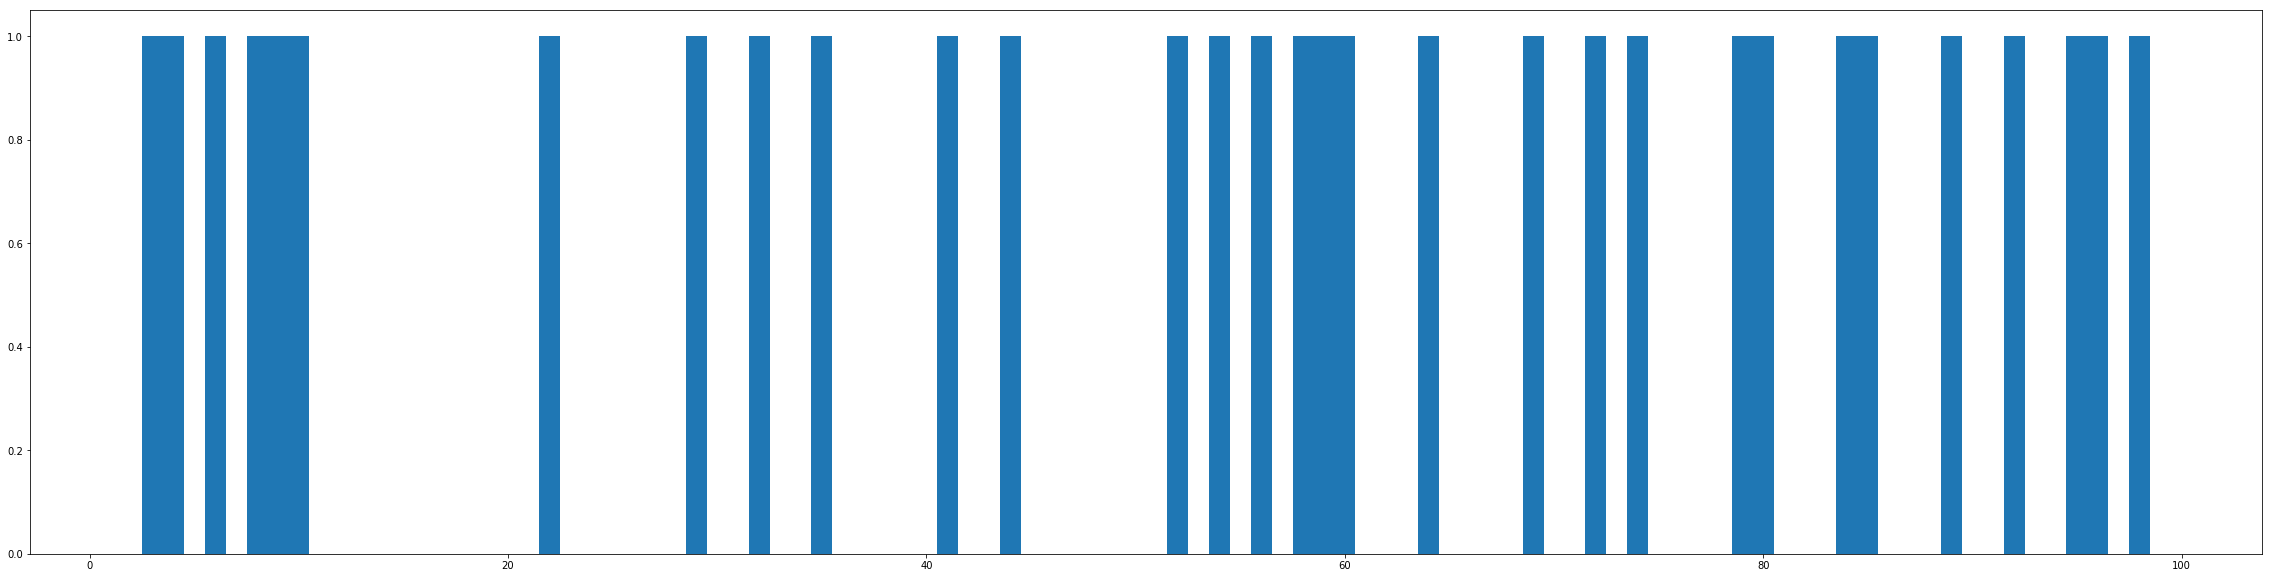

In [99]:
plt.figure(figsize=(40,10))
plt.bar(np.arange(0,100,1),y_pred_test_list_new[:100],y_test_list_new[:100])
#plt.plot(np.arange(0,100,1),y_pred_test_list_new[:100],color ='r')


F1 score for Test and Train:

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th> 
    <th>Train Accuracy</th>
    <th>Grid Search - Test Accuracy</th> 
    <th>Grid Search - Test Accuracy</th>
    <th>Test F1 Score</th> 
    <th>Train F1 Score</th>
    <th>Best Parameter</th>
    <th>Interpretability</th>
    <th>Reproducability</th>
  </tr>
  <tr>
    <th>Model-SupportVectorMachine</th>
    <th>0.6658</th> 
    <th>0.6844</th>
    <th>Grid Search Test - 0.6686</th> 
    <th>Grid Search Train - 0.6944</th>
    <th>0.66 </th> 
    <th>0.65</th>
    <th>{'C': 1, 'class_weight': 'balanced', 'degree': 3}</th>
     <th>Yes</th>
    <th>Non-reproducable</th>
  </tr>

</table>